# Natural language processing: spam detection

In [1]:
# Handle imports up-front
import regex as re
import pandas as pd
import matplotlib.pyplot as plt
from statistics import mean 
from sklearn.model_selection import train_test_split
from nltk import download
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from utils import cross_val

## 1. Data loading

### 1.1. Load the data

In [2]:
# Read csv file into dataframe
data_df=pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/NLP-project-tutorial/main/url_spam.csv')

# Drop duplicates if any
data_df.drop_duplicates(inplace=True)
data_df.reset_index(inplace=True, drop=True)

### 1.2. Inspect the data

In [3]:
data_df.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True


In [4]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2369 entries, 0 to 2368
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   url      2369 non-null   object
 1   is_spam  2369 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 20.9+ KB


### 1.3. Train-test split

In [5]:
# Separate features from labels
labels=data_df['is_spam']
features=data_df.drop('is_spam', axis=1)

# Encode the labels
encoded_labels=labels.apply(lambda x: 1 if x else 0).astype(int)

# Split the data into training and testing features and labels
training_features, testing_features, encoded_training_labels, encoded_testing_labels=train_test_split(
    features,
    encoded_labels,
    test_size=0.25,
    random_state=315
)

## 2. EDA

First, let's just take a look at how many 'spam' vs 'not spam' urls we have:

In [6]:
percent_spam=(sum(encoded_training_labels) / len(encoded_training_labels)) * 100
print(f'Training data is {percent_spam:.1f}% spam urls.')

Training data is 10.6% spam urls.


This is unbalanced, but not extremely so - we may not need to do anything with this information. But, it is good to keep it in mind as we work through EDA and modeling.

### 2.1. Text preprocessing

In [7]:
def preprocess_text(text):

    # Remove any character that is not a letter (a-z) or white space ( )
    text=re.sub(r'[^a-z ]', ' ', text)
    
    # Remove white spaces
    text=re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    text=re.sub(r'\^[a-zA-Z]\s+', ' ', text)

    # Multiple white spaces into one
    text=re.sub(r'\s+', ' ', text.lower())

    # Remove tags
    text=re.sub('&lt;/?.*?&gt;',' &lt;&gt; ', text)

    # Remove 'http', 'https' and 'www'
    text=re.sub('http', '', text)
    text=re.sub('https', '', text)
    text=re.sub('www', '', text)

    return text.split()

training_features['url']=training_features['url'].apply(preprocess_text)
training_features.head()

,url
311,"[s, nytimes, com, us, into, the, wild, bus, re..."
2317,"[s, digg, cmail, com, t, ptuurik, vkjjhbly, ih]"
1953,"[snarkmarket, com]"
1872,"[s, youtube, com, watch, d, u]"
1752,"[s, wired, com, story, amazon, shakes, self, d..."


### 2.2. Lematization

In [8]:
download('wordnet')
lemmatizer=WordNetLemmatizer()

download('stopwords')
stop_words=stopwords.words('english')

def lemmatize_text(words, lemmatizer=lemmatizer):
    tokens=[lemmatizer.lemmatize(word) for word in words]
    tokens=[word for word in tokens if word not in stop_words]
    tokens = [word for word in tokens if len(word) > 3]
    return tokens

training_features['url']=training_features['url'].apply(lemmatize_text)
training_features.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/siderealyear/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/siderealyear/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,url
311,"[nytimes, wild, removed, html]"
2317,"[digg, cmail, ptuurik, vkjjhbly]"
1953,[snarkmarket]
1872,"[youtube, watch]"
1752,"[wired, story, amazon, shake, self, driving, r..."


### 2.3. URL length distribution

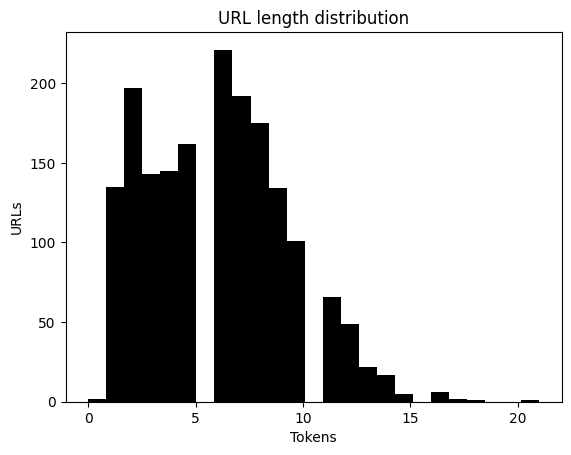

URL length mean: 6 tokens
URL length min: 0 tokens
URL length max: 21 tokens


In [9]:
# Get the lengths (in tokens)
lengths=[len(url) for url in training_features['url'].tolist()]

# Add it back to the data as a new feature
training_features['url_len']=lengths

plt.title('URL length distribution')
plt.xlabel('Tokens')
plt.ylabel('URLs')
plt.hist(lengths, bins=25, color='black')
plt.show()

print(f'URL length mean: {mean(lengths):.0f} tokens')
print(f'URL length min: {min(lengths):.0f} tokens')
print(f'URL length max: {max(lengths):.0f} tokens')

We have at least one URL with length zero after out text cleaning. Let's get rid of it.

In [10]:
# Add the labels back temporarily, so we can remove the corresponding label with url
training_features['target']=encoded_training_labels
training_features=training_features[training_features['url_len'] > 0]

# Re-separate the features and labels
encoded_training_labels=training_features['target']
training_features.drop(['target'], axis=1, inplace=True)

We also have some long urls, let's take a look at what they are and decide if we should exclude them.

In [11]:
training_features[training_features['url_len'] > 15]

,url,url_len
2159,"[washingtonpost, politics, court, supreme, cou...",16
219,"[judiciary, senate, press, release, chairman, ...",16
319,"[reuters, article, stock, weekahead, wall, str...",16
1866,"[washingtonpost, national, security, russian, ...",17
2334,"[reuters, article, russia, putin, vote, russia...",16
2077,"[blog, microsoft, blog, microsoft, launch, ini...",16
230,"[tulsaworld, news, trump, tulsa, president, at...",16
914,"[section, live, update, protest, racial, justi...",21
2160,"[washingtonpost, politics, court, supreme, cou...",17
2319,"[washingtonpost, world, europe, russia, prize,...",18


These mostly look like news sites that pack a lot of article key words into the URL. You could accuse them of key-word stuffing for SEO/sensationalism, but these are not obviously 'junk' data points. Let's keep them in.

### 2.4. Vectorization

In [18]:
# Extract the tokenized URLs and join the individual lists
tokens_list=training_features['url']
tokens_list=[' '.join(tokens) for tokens in tokens_list]

# Vectorize the URLs using TF-IDF
vectorizer=TfidfVectorizer(max_features=5000, max_df=0.8, min_df=5)
encoded_training_features=vectorizer.fit_transform(tokens_list).toarray()

# Get the words from the vector model
feature_names=vectorizer.get_feature_names_out()

# Convert the training data word counts back into a dataframe
encoded_training_features=pd.DataFrame(encoded_training_features, columns=feature_names)
print(f'Encoded features shape: {encoded_training_features.shape}')

Encoded features shape: (1774, 386)


In [19]:
# Take a look...
encoded_training_features.head()

,abortion,account,action,administration,advertising,afghanistan,ahead,album,amazon,america,...,wordpress,work,worker,world,wwdc,year,york,youtu,youtube,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.702264,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.41855,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


### 2.4. Mean TF-IDF value distribution

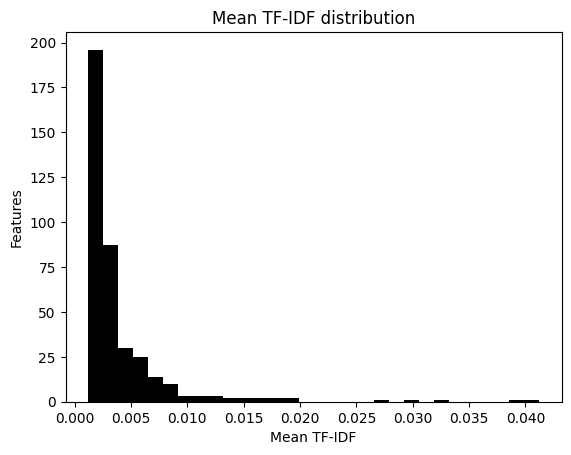

In [20]:
# Get the mean TF-IDF value for each feature
feature_means=encoded_training_features.mean().tolist()

plt.title('Mean TF-IDF distribution')
plt.xlabel('Mean TF-IDF')
plt.ylabel('Features')
plt.hist(feature_means, bins=30, color='black')
plt.show()

There are a lot of features with zero or very small TF-IDF values. This is not super surprising, this type of data is often very sparse. We could try re-running the vectorization with a higher *min_df* cutoff, but I think we should just leave it alone for now.

## 3. SVM model

### 3.1. Baseline model performance

In [21]:
# Instantiate the support vector machine classifier with defaults
baseline_model=SVC(random_state=315)

# Cross-validate the default model on the encoded training data
scores=cross_val(baseline_model, encoded_training_features, encoded_training_labels)

# Save the baseline cross-validation scores for later
results={'Baseline': scores}

Cross-validation accuracy: 93.63 +/- 1.03%


### 3.2. Hyperparameter optimization

In [22]:
# Set the hyperparameter search space
hyperparameters = {
    'C': [0.01, 0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto']
}

# Instantiate a new model
model=SVC(random_state=315)

# Set up the grid search
grid=GridSearchCV(model, hyperparameters, scoring='accuracy', cv=5, n_jobs=-1)

# Run the search
optimization_results=grid.fit(encoded_training_features, encoded_training_labels)

print(f'Best hyperparameters: {grid.best_params_}')

Best hyperparameters: {'C': 1, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'}


In [17]:
# Cross-validate the model with the winning hyperparameters
optimized_model=SVC(**grid.best_params_, random_state=315)
scores=cross_val(optimized_model, encoded_training_features, encoded_training_labels)

# Save the baseline cross-validation scores for later
results={'Optimized model': scores}

Cross-validation accuracy: 91.09 +/- 1.50%


## 4. Model evaluation